In [34]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lmfit import Model
import matplotlib.ticker as ticker

In [35]:
# Functions

def line(x, m, b):
    return x * m + b

def tlm(s, r_s, N, w, L, r_c):
    return ((r_s * s) / (2 * N * (w + L + s) - L - s)) + (2 * r_c)

def tlm2(s, r_s, N, w, L, l_t):
    return (r_s / (2 * N * (w + L + s) - L - s)) * (s + 2 * l_t)

def w_contact(s, N, w, L):
    return (2 * N * (w + L + s)) - L - s

In [36]:
# Models

line_mod = Model(line)
line_params = line_mod.make_params(m = 1, b = 1)

# Considering L_t to get \rho_c Contact Resistivity
tlm_mod2 = Model(tlm2)
tlm2_params = tlm_mod2.make_params()
tlm2_params['r_s'].set(value = 1e6)
tlm2_params['N'].set(value = 60, vary = False)
tlm2_params['w'].set(value = 5e-4, vary = False)
tlm2_params['L'].set(value = 3200e-4, vary = False)
tlm2_params['l_t'].set(value = 1e-5, min = 0)

In [37]:
# Settings

col = ['Potential (V)', 'Current (A)', 'Time (s)']
col2 = ['Structure', 'Spacing (cm)', 'Resistance ($\Omega$)']
idea2 = {'P01': 2e-4,
         'P02': 5e-4,
         'P03': 10e-4,
         'P04' : 20e-4
         }

formatter = ticker.FuncFormatter(lambda x, pos: "{:.1f}".format(x / 1e6))
formatter_1 = ticker.FuncFormatter(lambda x, pos: "{:.1f}".format(x * 1e4))
formatter_2 = ticker.FuncFormatter(lambda x, pos: "{:.1f}".format(x * 1e6))

palette = 'viridis'

In [47]:
# Function to process data

def C_R(path, thickness, sample):
    
    files = [os.path.join(path, i) for i in os.listdir(path)]
    iv_val = pd.DataFrame(columns = col2)
    iv_df = pd.DataFrame()
    n = 0
    for i in files:
        directory, filename = os.path.split(i)
        df = pd.read_csv(i, sep = ';', skiprows = 1, names = col)
        df['Device'] = filename[:-4]
        # df['dI/dV'] = np.gradient(df[col[1]], df[col[0]])
        
        for structure in idea2.keys():
            if structure in filename:
                df['Spacing ($\mu$m)'] = idea2[structure] *1e4
        
        line_fit = line_mod.fit(df[col[1]], line_params, x = df[col[0]])
        slope = line_fit.values['m']
        resistance = 1 / slope
        
        for j in idea2.keys():
            if j in filename:
                iv_val.loc[n] = (j, idea2[j], resistance)
                
        # df['Norm dI/dV'] = df['dI/dV'] / slope
        iv_df = pd.concat([iv_df, df], ignore_index = True)
        
        n += 1
    iv_df['Sample'] = sample
    iv_val['Sample'] = sample
    # print(iv_df)

    width_ = (w_contact(iv_val[col2[1]], 60, 5e-4, 3200e-4))
    width_avg = width_.mean()

    all_avg = pd.DataFrame()
    u_s = iv_val.Structure.unique()
    df_dict = {i : pd.DataFrame() for i in u_s}
    
    for key in df_dict.keys():
        df_dict[key] = iv_val[:][iv_val.Structure == key]
        
    for key, df in df_dict.items():
        mean_ = df.mean(numeric_only = True).reset_index().transpose()
        mean_.columns = mean_.iloc[0]
        mean_ = mean_[1:].reset_index(drop=True)
        all_avg = pd.concat([all_avg, mean_], ignore_index = True)
    
    
    tlm_fit2 = tlm_mod2.fit(all_avg[col2[2]], tlm2_params, s = all_avg[col2[1]])   
    # using the average for the fit. Same values, lower numerical error 
    # tlm_fit2 = tlm_mod2.fit(iv_val[col2[2]], tlm2_params, s = iv_val[col2[1]])
    
    # print(tlm_fit2.fit_report())
    rc = tlm_mod2.eval(tlm_fit2.params, s = 0) / 2
    lt = tlm_fit2.values['l_t']
    p_c = rc * lt * width_avg #Contact resistiviy ohm * cm^2
    # sigma = (1 / tlm_fit2.values['r_s'] ) / (thickness * 1e-7 * width_avg)
    sigma = 1 / (tlm_fit2.values['r_s'] * thickness * 1e-7)
    r_s = tlm_fit2.values['r_s']

    print('Contact Resistivity = ' + str(p_c) + ' Ohm cm2')
    print('LMO conductivity = ' + str(sigma) + ' S/cm')
    
    
    # Plot
    fig, ax = plt.subplots(1, 2, figsize = (15,5), dpi = 200) #    1, 2, figsize = (15,5),
    
    cross_zero = np.array([-2, 0, 20]) * 1e-4
    y_zero = tlm_mod2.eval(tlm_fit2.params, s = cross_zero)
    
    sns.lineplot(data = iv_val, x = col2[1], y = col2[2], marker='o', markersize = 8, errorbar='sd',err_style='bars', linestyle='')
    sns.lineplot(x = cross_zero, y = y_zero)
    
    plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)  # Horizontal zero line
    plt.axvline(0, color='gray', linestyle='--', linewidth=0.5)  # Vertical zero line
    
    ax[1].set_xlabel('Spacing ($\mu$m)')
    ax[1].set_ylabel('Resistance ($\Omega$)')
    # ax[1].yaxis.set_major_formatter(formatter)
    ax[1].xaxis.set_major_formatter(formatter_1)
    #
    sns.scatterplot(data = iv_val, x = col2[1], y = col2[2], ax = ax[0])
    
    fig, ax = plt.subplots(dpi = 200)
    sns.lineplot(data = iv_df, x = 'Potential (V)', y = 'Current (A)', hue = 'Spacing ($\mu$m)')
    ax.yaxis.set_major_formatter(formatter_2)
    ax.set_ylabel('Current ($\mu$A)')
    
    fit_vals = pd.DataFrame({'Sheet Resistance' : [r_s],
                'Contact Resistance' : [rc],
                'Transfer Lenght' : [lt],
                'Contact Resistivity' : [p_c],
                'Conductivity' : [sigma],
                'Sample' : [sample]})
    
    result = iv_val, tlm_fit2, fit_vals, iv_df
    
    return result

Contact Resistivity = 2.8385800667687286 Ohm cm2
LMO conductivity = 4.996605160343089e-05 S/cm
[[Model]]
    Model(tlm2)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 76
    # data points      = 4
    # variables        = 2
    chi-square         = 106027.479
    reduced chi-square = 53013.7393
    Akaike info crit   = 44.7406368
    Bayesian info crit = 43.5132256
    R-squared          = 0.99974366
[[Variables]]
    r_s:  5.7182e+08 +/- 6453022.55 (1.13%) (init = 1000000)
    N:    60 (fixed)
    w:    0.0005 (fixed)
    L:    0.32 (fixed)
    l_t:  7.0358e-05 +/- 7.1266e-06 (10.13%) (init = 1e-05)
[[Correlations]] (unreported correlations are < 0.100)
    C(r_s, l_t) = -0.841


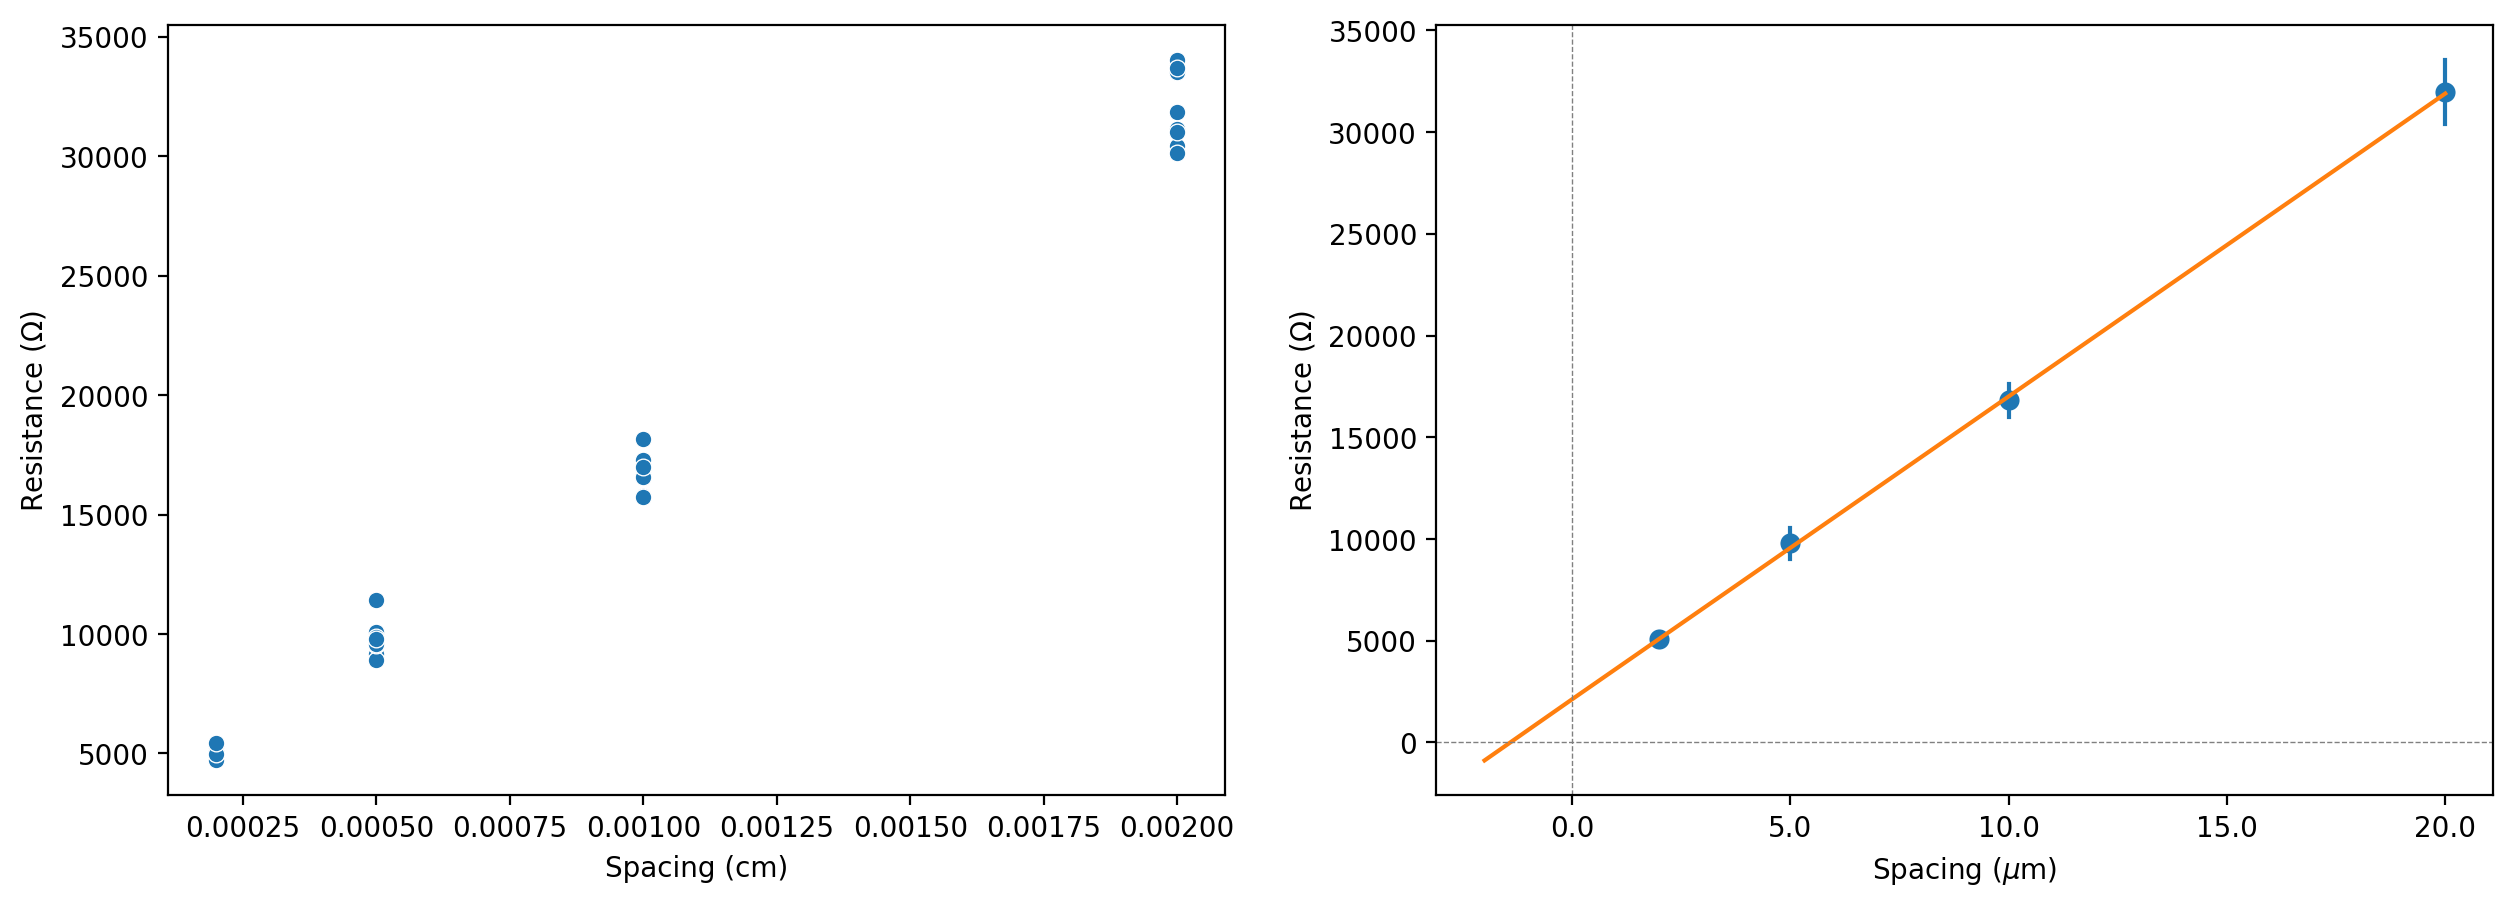

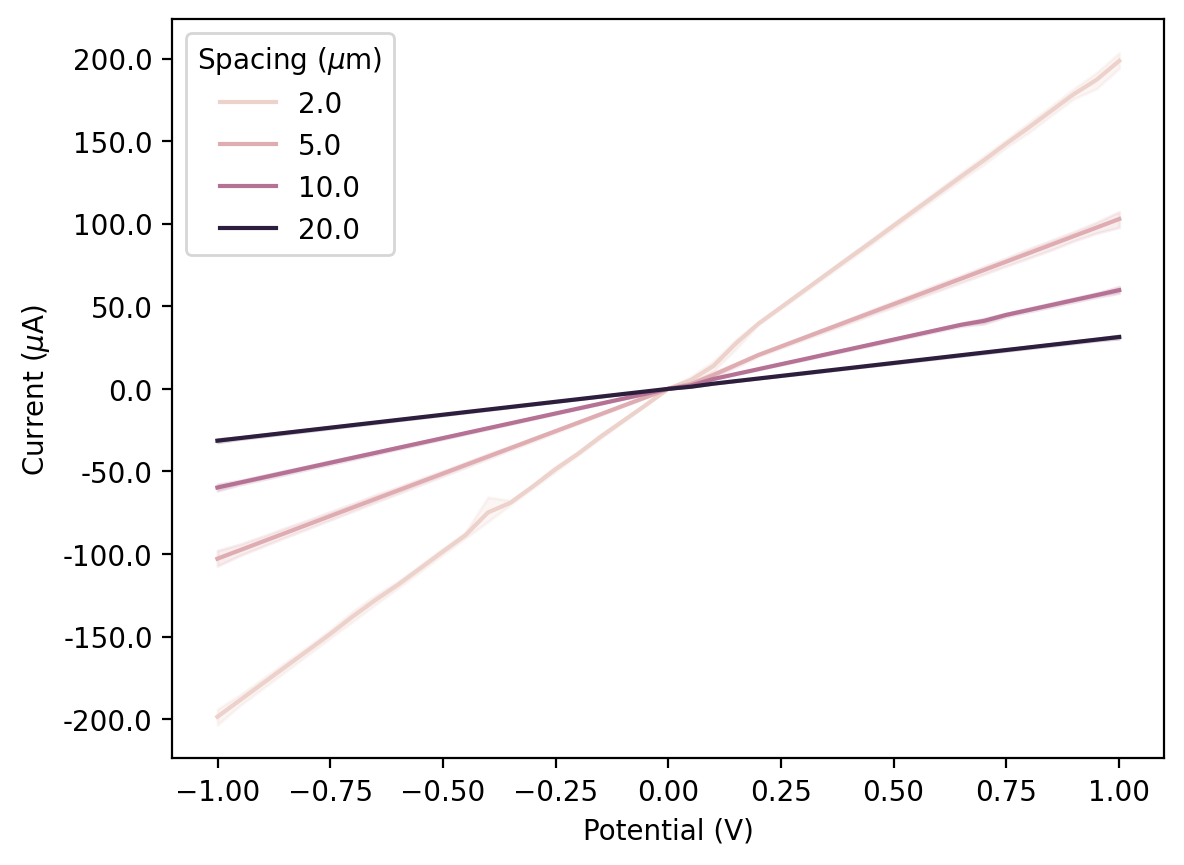

In [48]:
# TI2_03 LMO 8h
path = r'C:\Users\lopezb41\OneDrive - imec\Documents\Experiments\Data\Contact Resistance\IDEA2_TLM\LMO8h_Pt'
sample = 'LMO 350nm/Pt 100nm'
lmo8h_pt = C_R(path, 350, sample) # , lmo8h_pt_fit, lmo8h_pt_fit_vals, lmo8h_pt_iv_curves
print(lmo8h_pt[1].fit_report())

Contact Resistivity = 6.031928117867041 Ohm cm2
LMO conductivity = 5.006030570321461e-05 S/cm
[[Model]]
    Model(tlm2)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 79
    # data points      = 4
    # variables        = 2
    chi-square         = 13101.3364
    reduced chi-square = 6550.66821
    Akaike info crit   = 36.3767006
    Bayesian info crit = 35.1492894
    R-squared          = 0.99996819
[[Variables]]
    r_s:  5.7074e+08 +/- 2268358.90 (0.40%) (init = 1000000)
    N:    60 (fixed)
    w:    0.0005 (fixed)
    L:    0.32 (fixed)
    l_t:  1.0266e-04 +/- 2.6189e-06 (2.55%) (init = 1e-05)
[[Correlations]] (unreported correlations are < 0.100)
    C(r_s, l_t) = -0.855


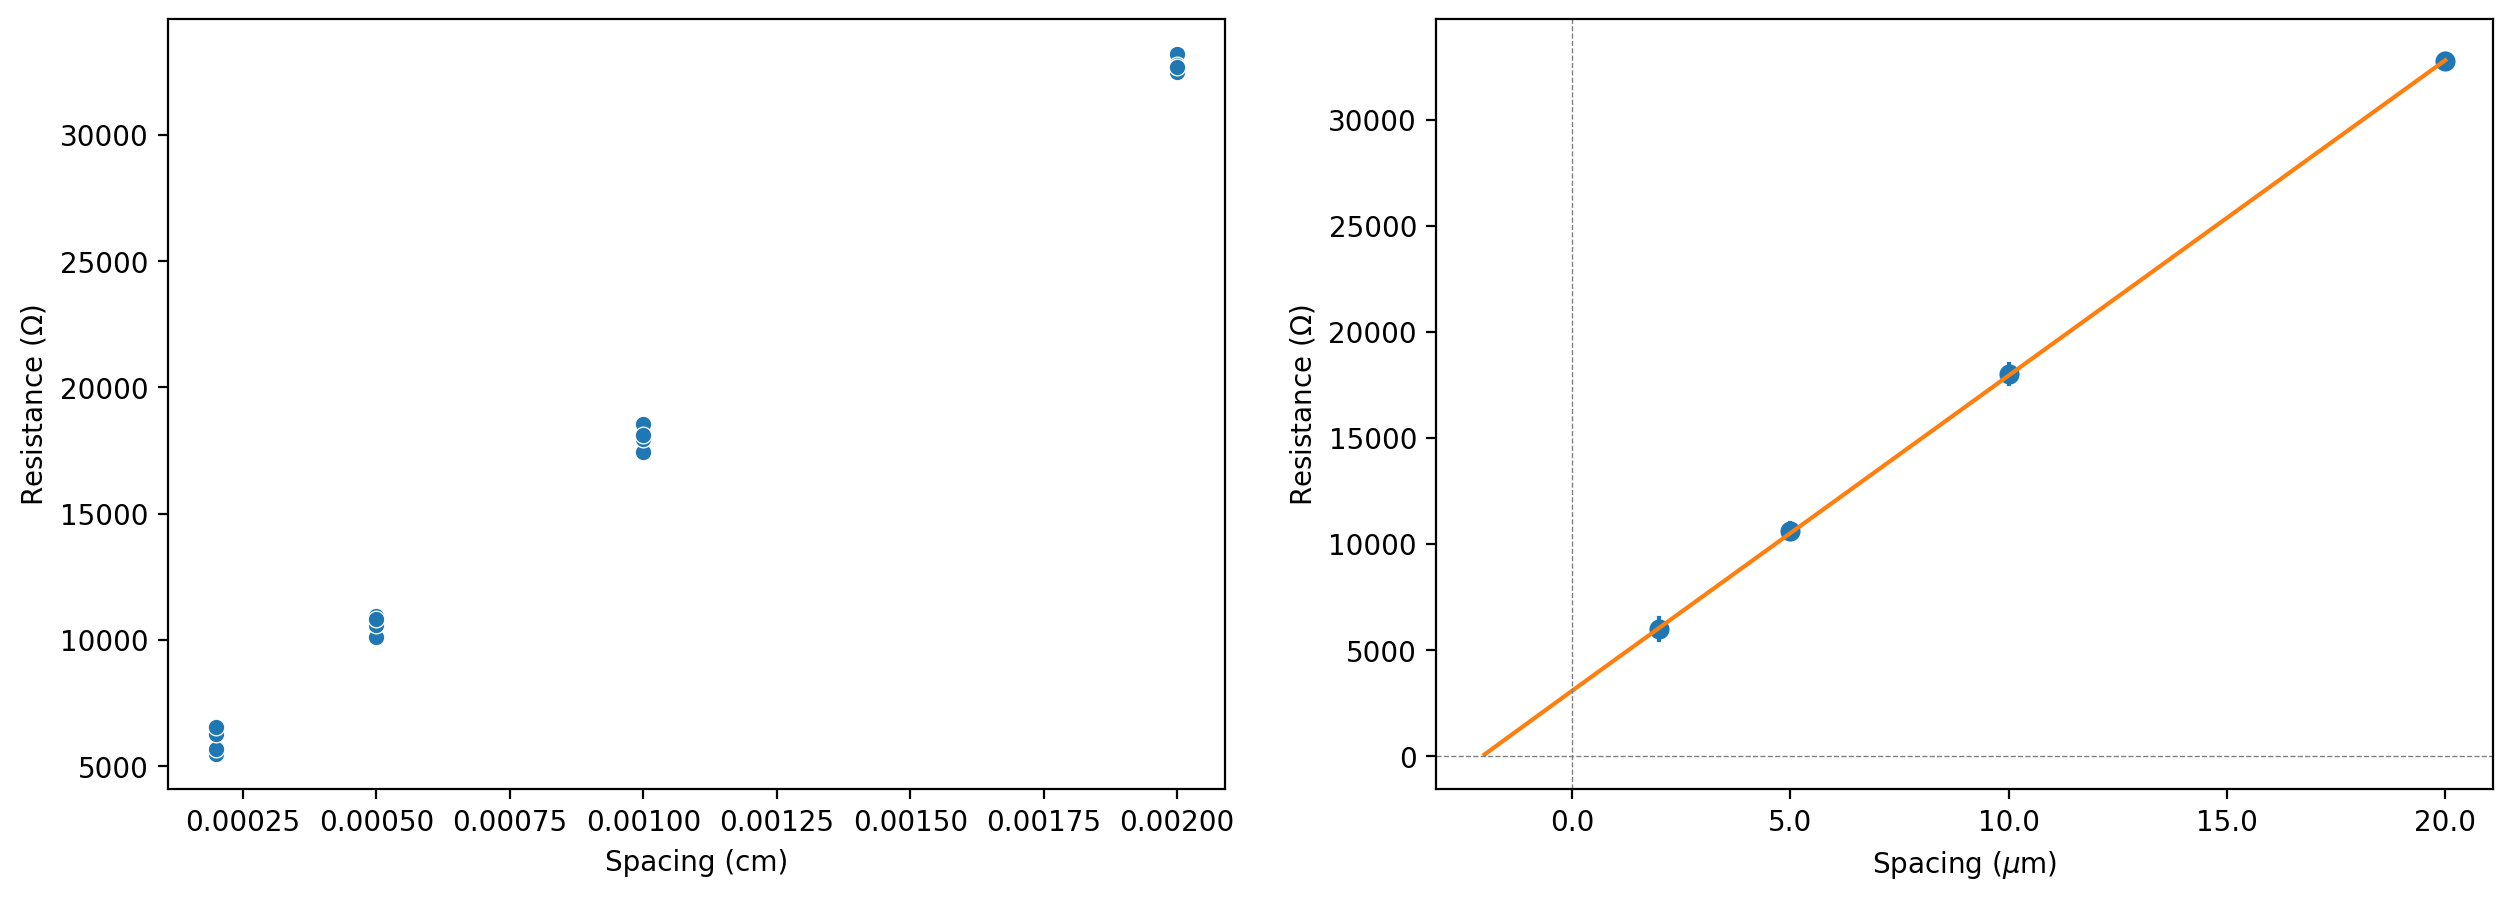

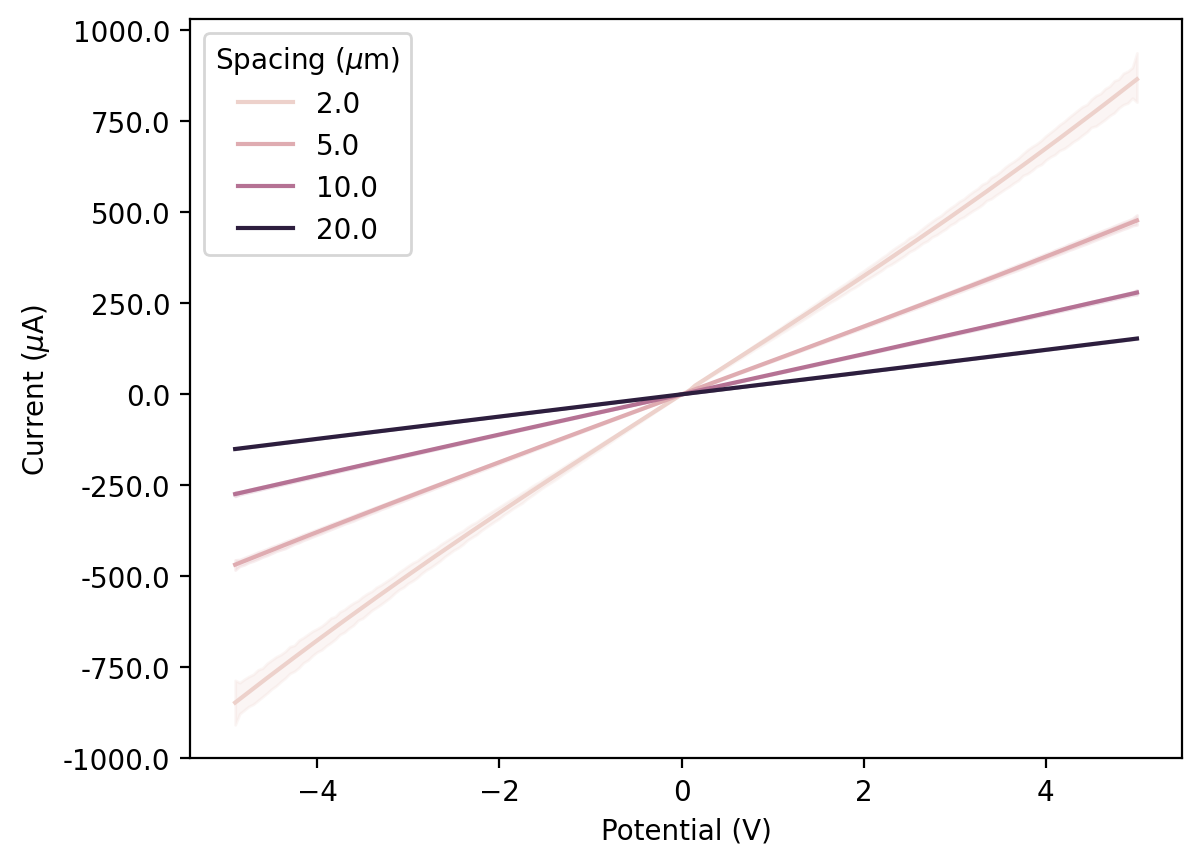

In [49]:
#LMO8h Pt Sample 2
path = r'C:\Users\lopezb41\OneDrive - imec\Documents\Experiments\Data\Contact Resistance\IDEA2_TLM\LMO8h_Pt_20231029'
sample = 'LMO 350nm/Pt 100nm 2'
lmo8h_pt2 = C_R(path, 350, sample)
print(lmo8h_pt2[1].fit_report())

Contact Resistivity = 3.7237949065978593 Ohm cm2
LMO conductivity = 4.996704972888169e-05 S/cm
[[Model]]
    Model(tlm2)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 76
    # data points      = 4
    # variables        = 2
    chi-square         = 54982.3487
    reduced chi-square = 27491.1744
    Akaike info crit   = 42.1138925
    Bayesian info crit = 40.8864812
    R-squared          = 0.99986703
[[Variables]]
    r_s:  5.7181e+08 +/- 4646924.35 (0.81%) (init = 1000000)
    N:    60 (fixed)
    w:    0.0005 (fixed)
    L:    0.32 (fixed)
    l_t:  8.0585e-05 +/- 5.2025e-06 (6.46%) (init = 1e-05)
[[Correlations]] (unreported correlations are < 0.100)
    C(r_s, l_t) = -0.846
4.05e-07


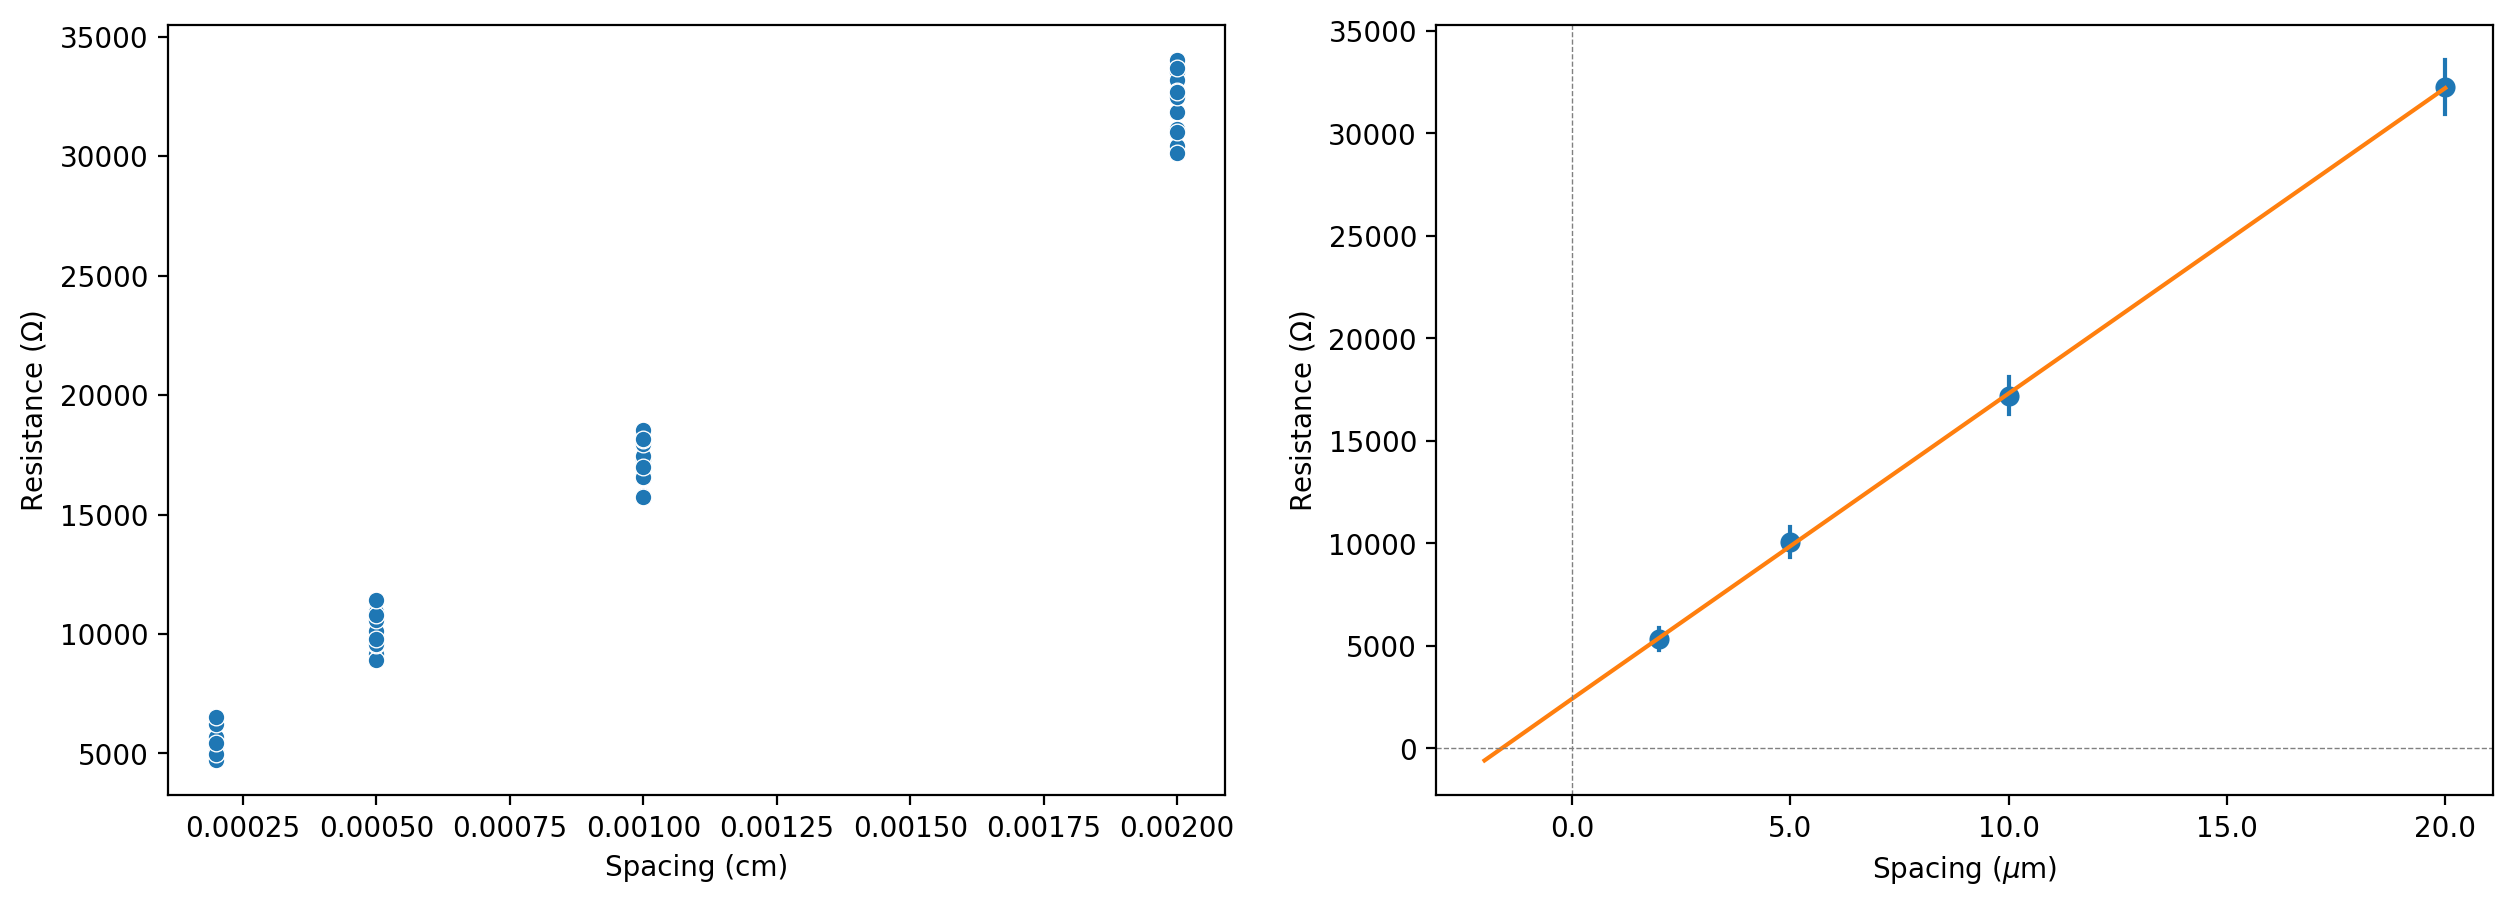

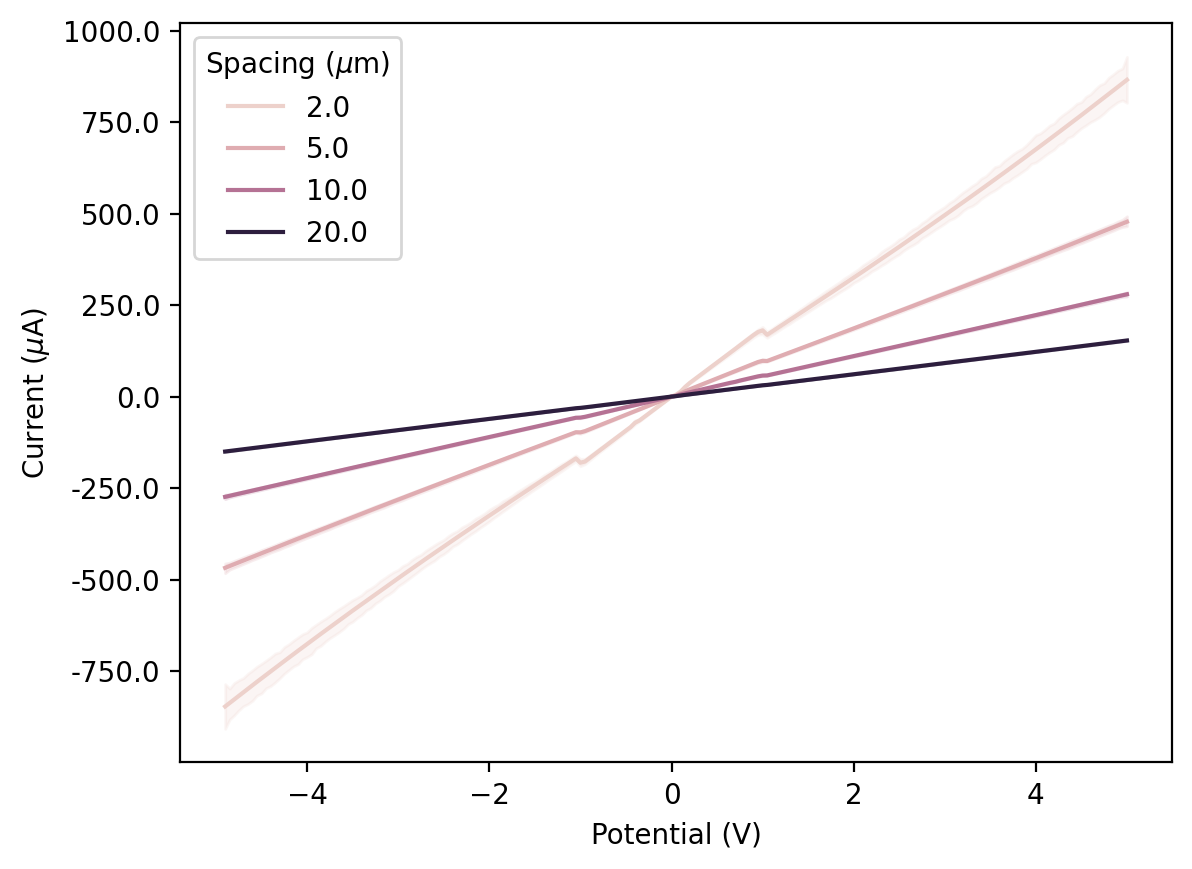

In [51]:
# LMO8h Pt 1 and 2
path = r'C:\Users\lopezb41\OneDrive - imec\Documents\Experiments\Data\Contact Resistance\IDEA2_TLM\LMO8h_Pt_1_2'
sample = 'LMO 350nm/Pt 100nm'
lmo8h_pt12 = C_R(path, 350, sample)
print(lmo8h_pt12[1].fit_report())


In [54]:
0.0295 * 49.21

1.451695

Contact Resistivity = 49.214201776130686 Ohm cm2
LMO conductivity = 4.858358067680382e-05 S/cm
[[Model]]
    Model(tlm2)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 81
    # data points      = 4
    # variables        = 2
    chi-square         = 93960.9758
    reduced chi-square = 46980.4879
    Akaike info crit   = 44.2573619
    Bayesian info crit = 43.0299506
    R-squared          = 0.99978464
[[Variables]]
    r_s:  5.8809e+08 +/- 6074740.33 (1.03%) (init = 1000000)
    N:    60 (fixed)
    w:    0.0005 (fixed)
    L:    0.32 (fixed)
    l_t:  2.8887e-04 +/- 8.5104e-06 (2.95%) (init = 1e-05)
[[Correlations]] (unreported correlations are < 0.100)
    C(r_s, l_t) = -0.910


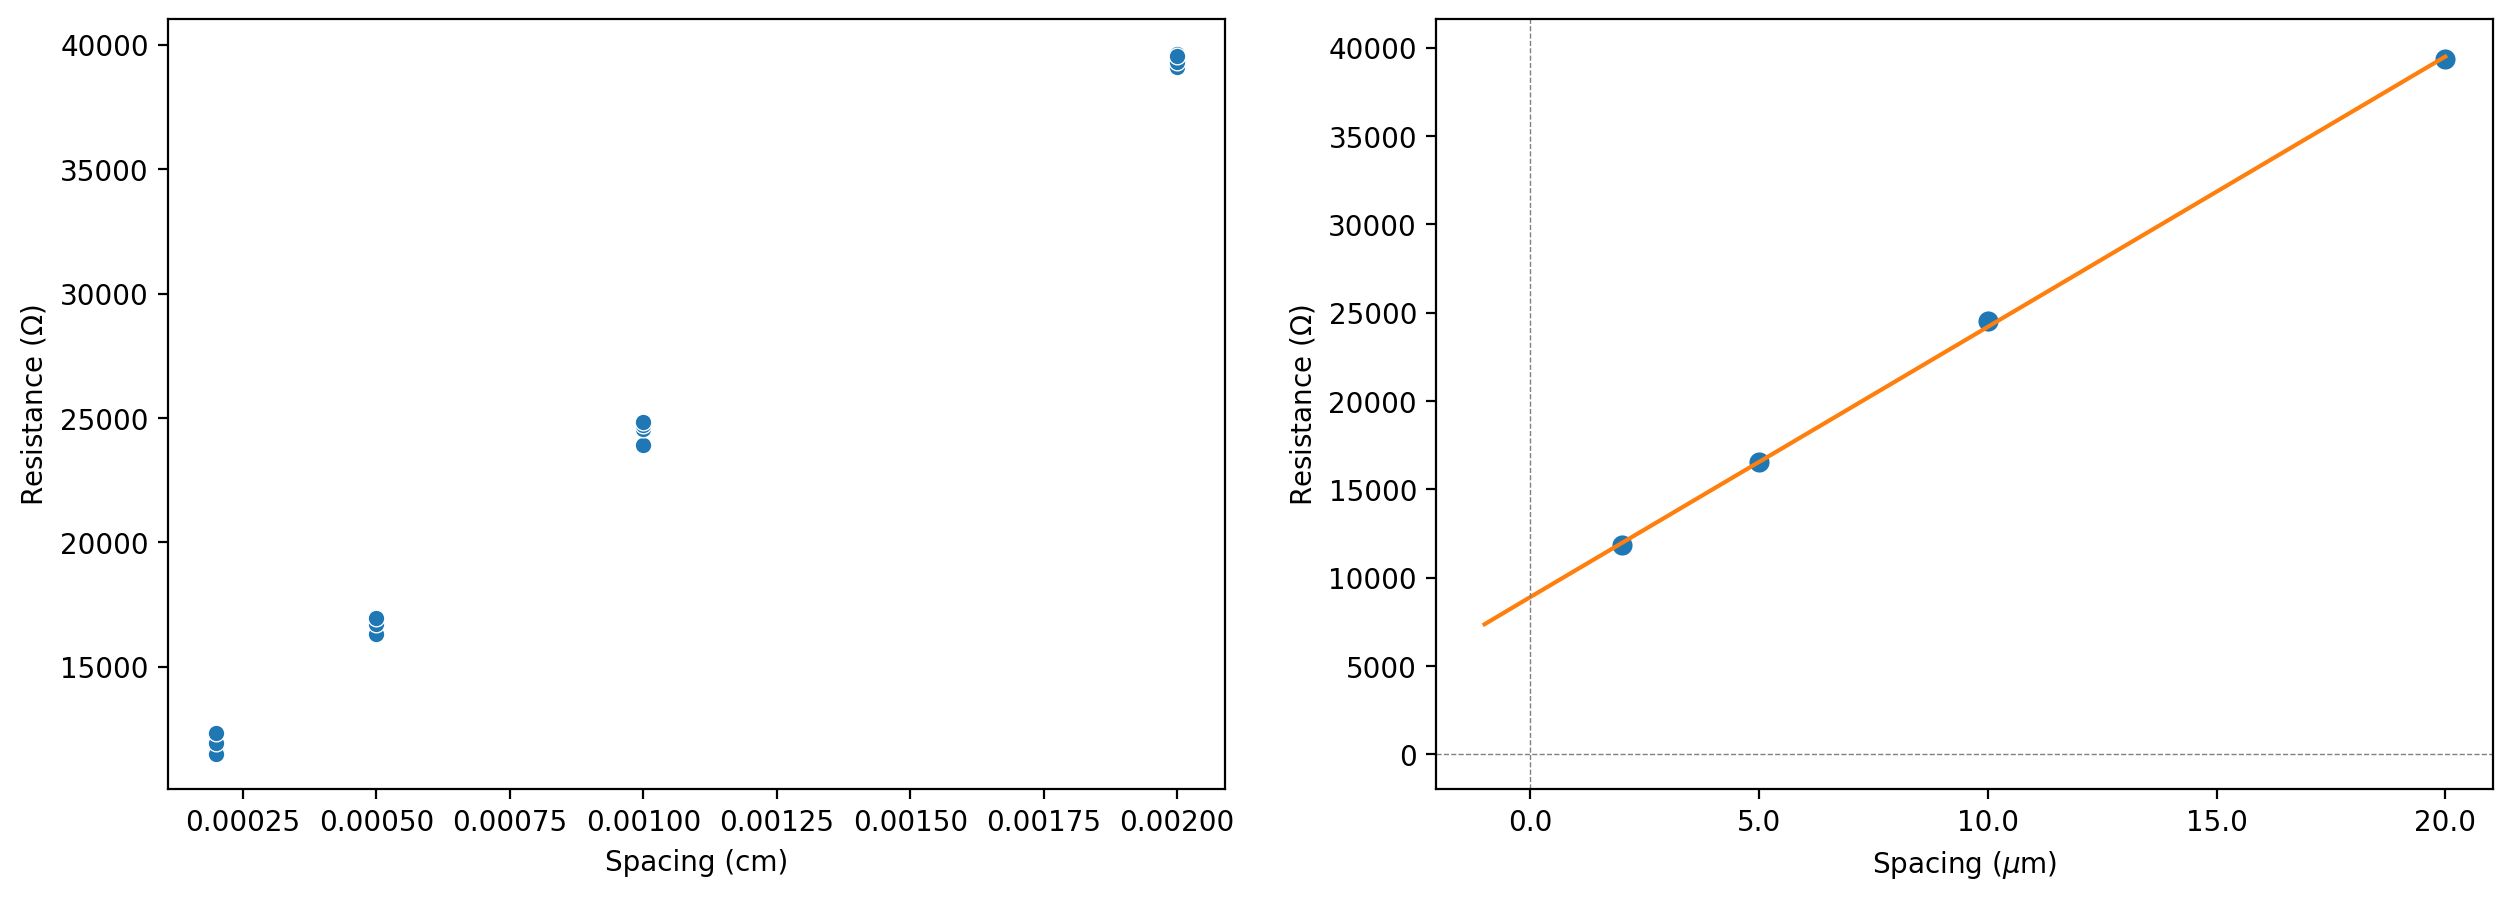

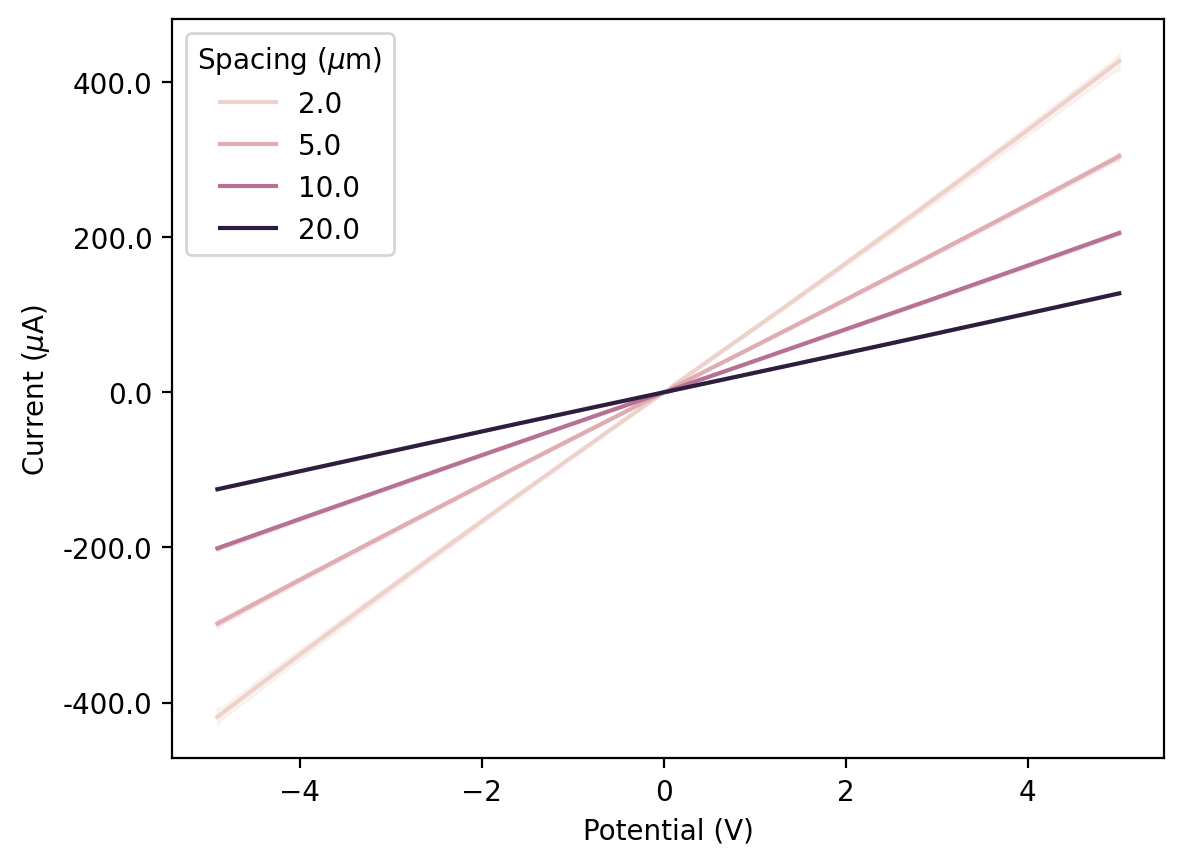

In [41]:
#LMO8h ITO
path = r'C:\Users\lopezb41\OneDrive - imec\Documents\Experiments\Data\Contact Resistance\IDEA2_TLM\LMO8h_ITO_20231029'
sample = 'LMO 350nm/ITO'
lmo8h_ito = C_R(path, 350, sample)
print(lmo8h_ito[1].fit_report())

Contact Resistivity = 21.096612332772484 Ohm cm2
LMO conductivity = 1.2347705884330594e-05 S/cm
[[Model]]
    Model(tlm2)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 97
    # data points      = 4
    # variables        = 2
    chi-square         = 3673544.67
    reduced chi-square = 1836772.33
    Akaike info crit   = 58.9214930
    Bayesian info crit = 57.6940817
    R-squared          = 0.99945761
[[Variables]]
    r_s:  2.3139e+09 +/- 37983645.1 (1.64%) (init = 1000000)
    N:    60 (fixed)
    w:    0.0005 (fixed)
    L:    0.32 (fixed)
    l_t:  9.5347e-05 +/- 1.0715e-05 (11.24%) (init = 1e-05)
[[Correlations]] (unreported correlations are < 0.100)
    C(r_s, l_t) = -0.852


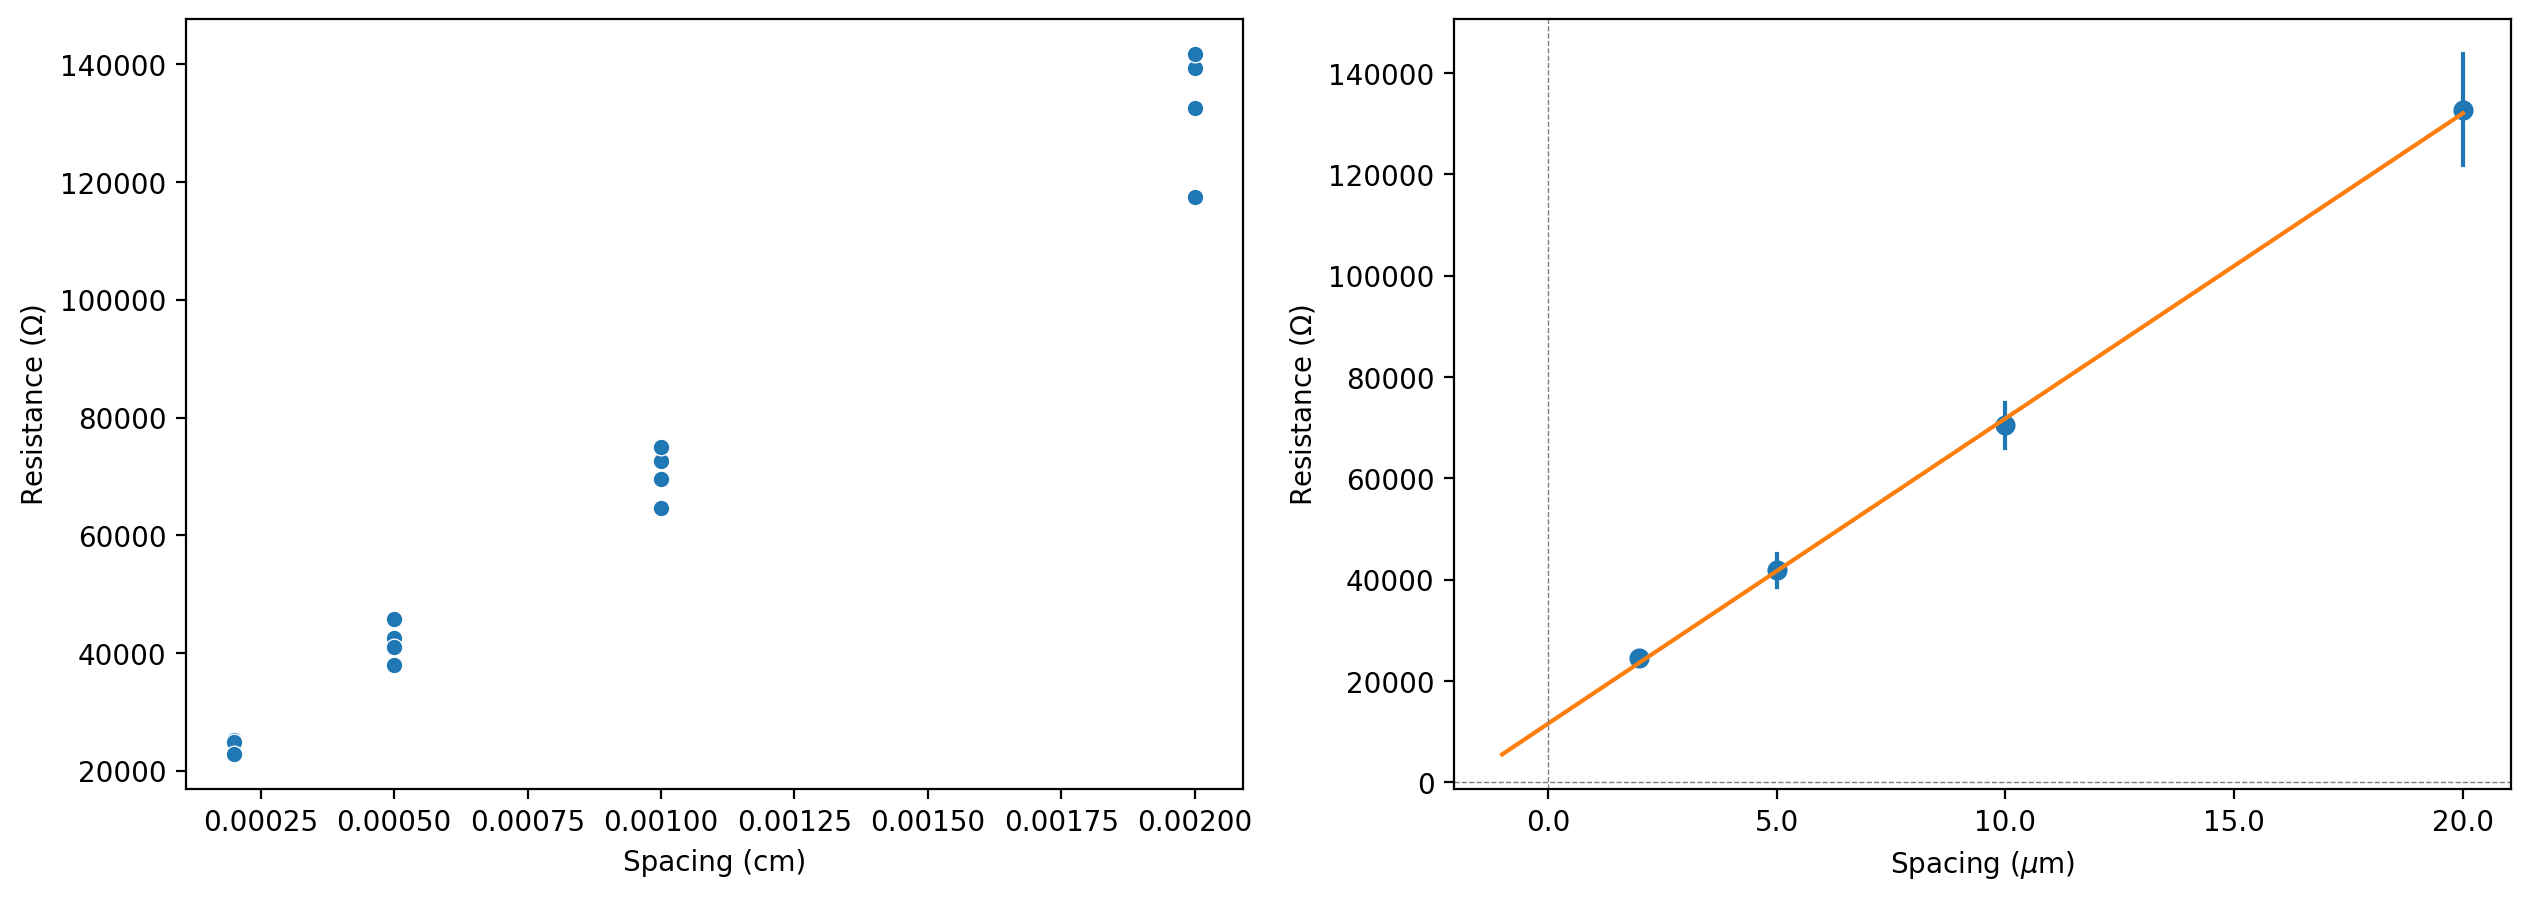

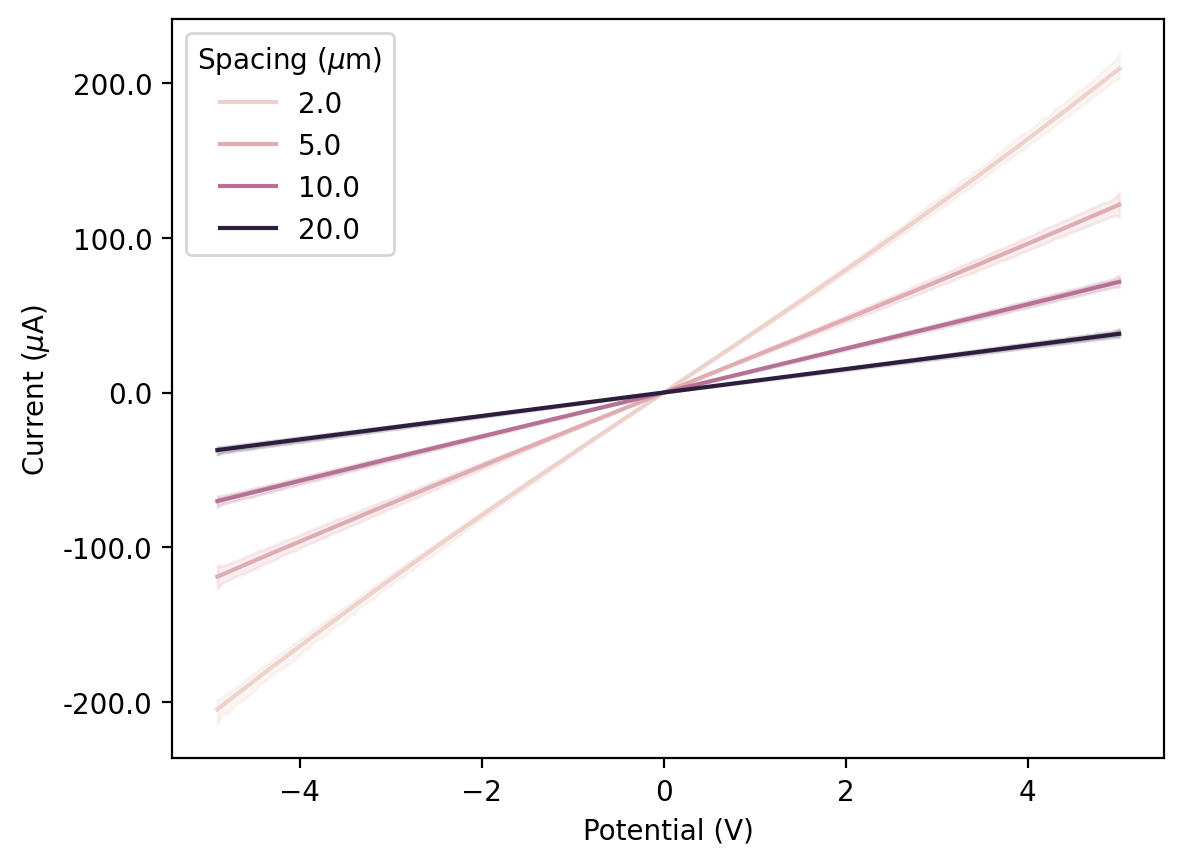

In [42]:
# LMO8h Au
path = r'C:\Users\lopezb41\OneDrive - imec\Documents\Experiments\Data\Contact Resistance\IDEA2_TLM\LMO8h_Au_20231106\1'
sample = 'LMO 350/Au'
lmo8h_au = C_R(path, 350, sample)
print(lmo8h_au[1].fit_report())


Contact Resistivity = 17.303910960504467 Ohm cm2
LMO conductivity = 1.8529933467154544e-05 S/cm
[[Model]]
    Model(tlm2)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 94
    # data points      = 4
    # variables        = 2
    chi-square         = 266945.553
    reduced chi-square = 133472.777
    Akaike info crit   = 48.4340225
    Bayesian info crit = 47.2066113
    R-squared          = 0.99991119
[[Variables]]
    r_s:  1.5419e+09 +/- 10239182.9 (0.66%) (init = 1000000)
    N:    60 (fixed)
    w:    0.0005 (fixed)
    L:    0.32 (fixed)
    l_t:  1.0578e-04 +/- 4.3935e-06 (4.15%) (init = 1e-05)
[[Correlations]] (unreported correlations are < 0.100)
    C(r_s, l_t) = -0.857


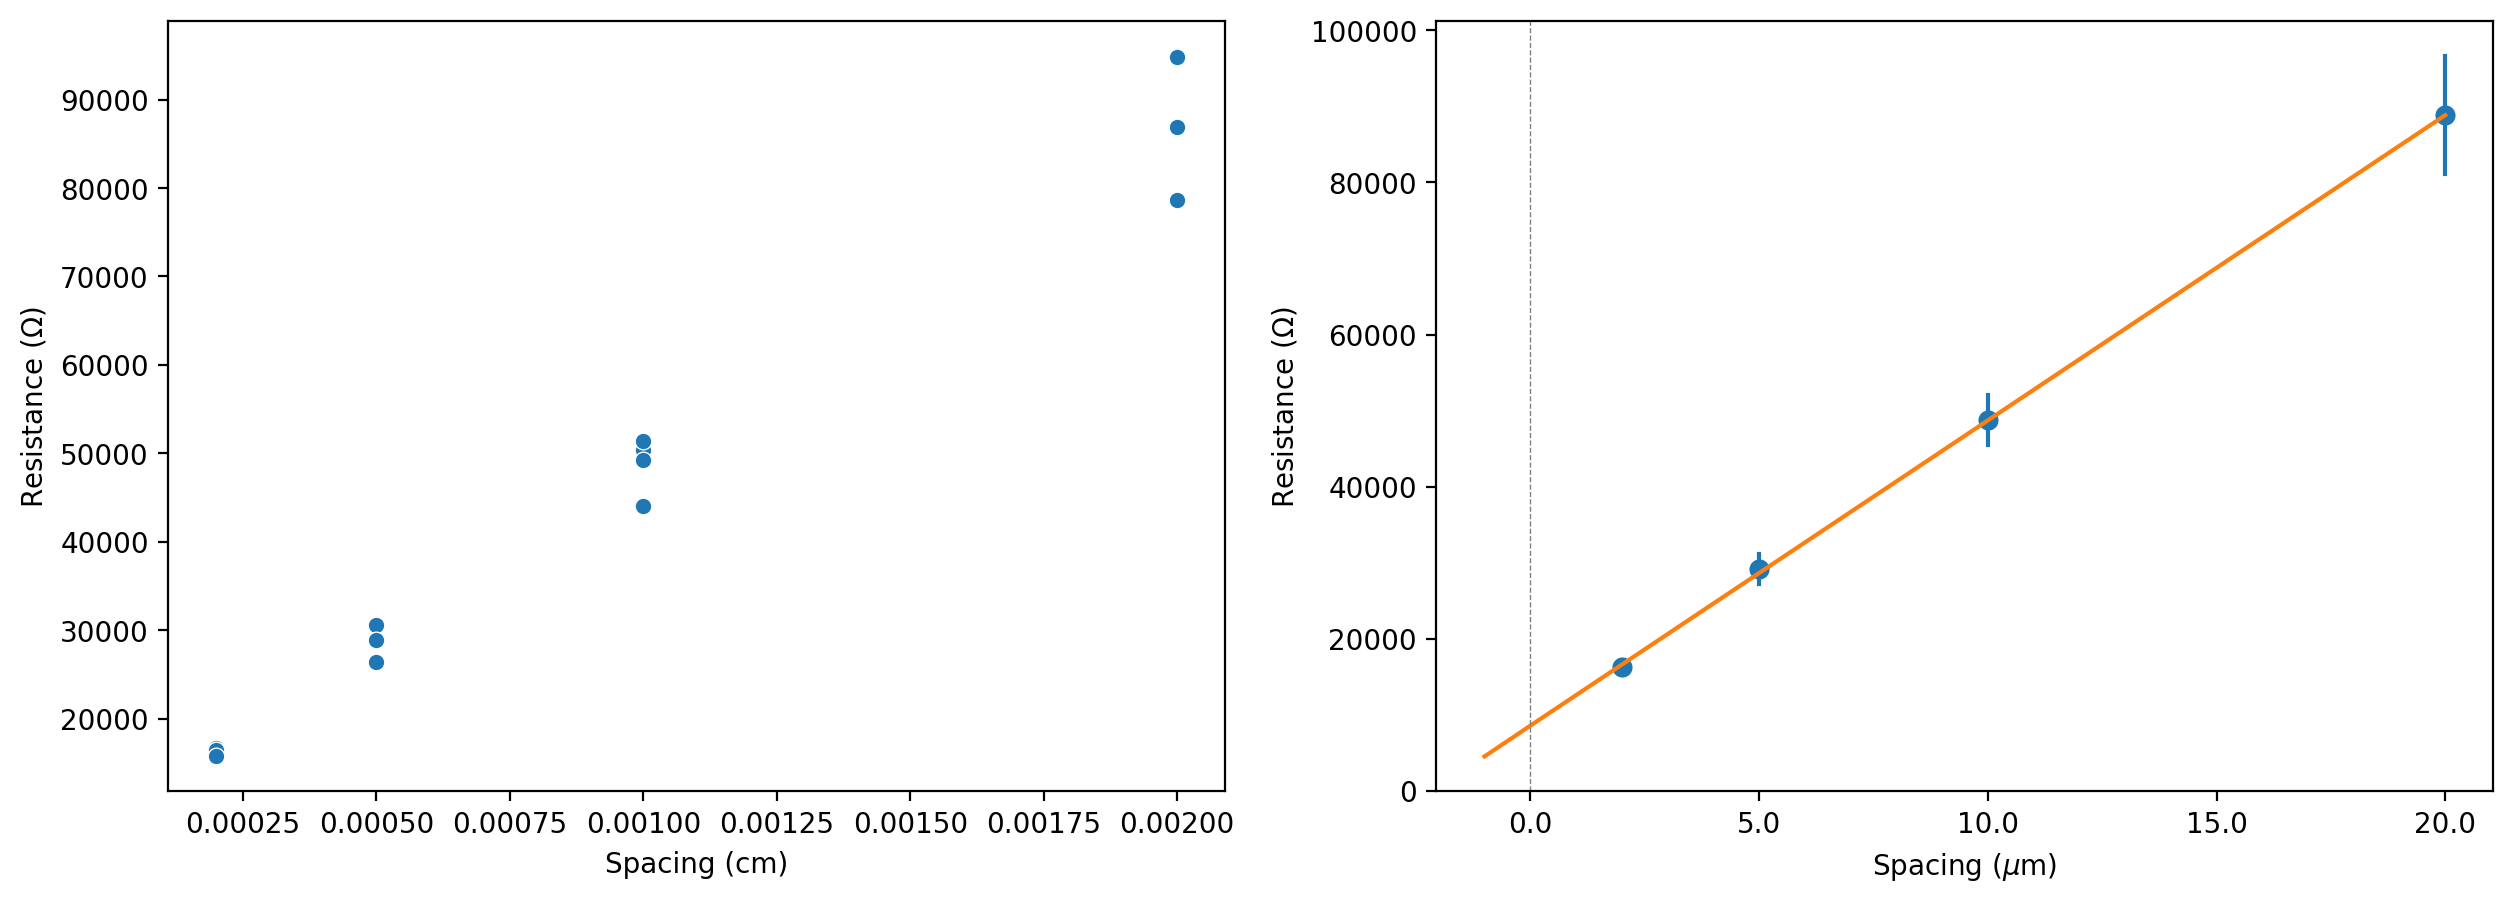

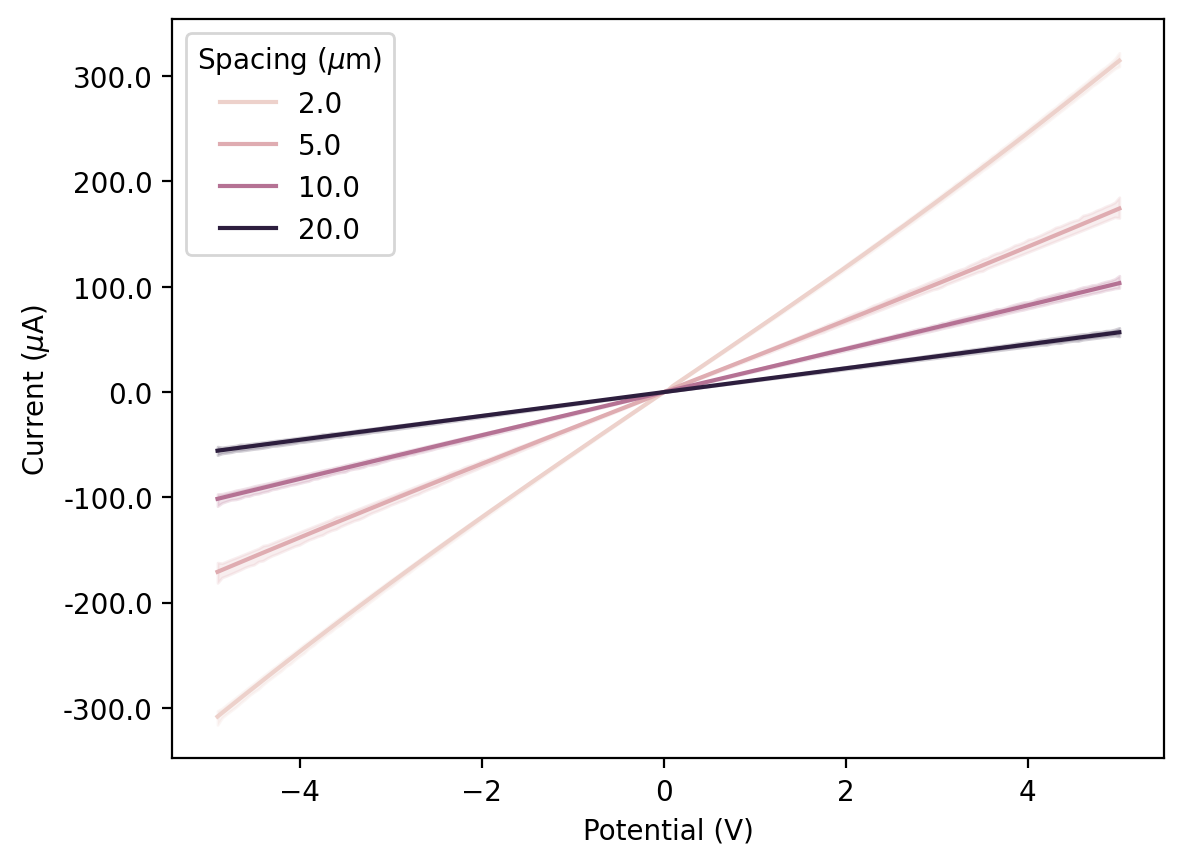

In [43]:
# LMO8h Au2
path = r'C:\Users\lopezb41\OneDrive - imec\Documents\Experiments\Data\Contact Resistance\IDEA2_TLM\LMO8h_Au_20231106\2'
sample = 'LMO 350/Au 2'
lmo8h_au2 = C_R(path, 350, sample)
print(lmo8h_au2[1].fit_report())


In [57]:
.0641 * 19.15

1.227515

Contact Resistivity = 19.14972640663463 Ohm cm2
LMO conductivity = 1.4819926214496835e-05 S/cm
[[Model]]
    Model(tlm2)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 91
    # data points      = 4
    # variables        = 2
    chi-square         = 895111.987
    reduced chi-square = 447555.993
    Akaike info crit   = 53.2736390
    Bayesian info crit = 52.0462277
    R-squared          = 0.99980954
[[Variables]]
    r_s:  1.9279e+09 +/- 18749627.5 (0.97%) (init = 1000000)
    N:    60 (fixed)
    w:    0.0005 (fixed)
    L:    0.32 (fixed)
    l_t:  9.9520e-05 +/- 6.3821e-06 (6.41%) (init = 1e-05)
[[Correlations]] (unreported correlations are < 0.100)
    C(r_s, l_t) = -0.854


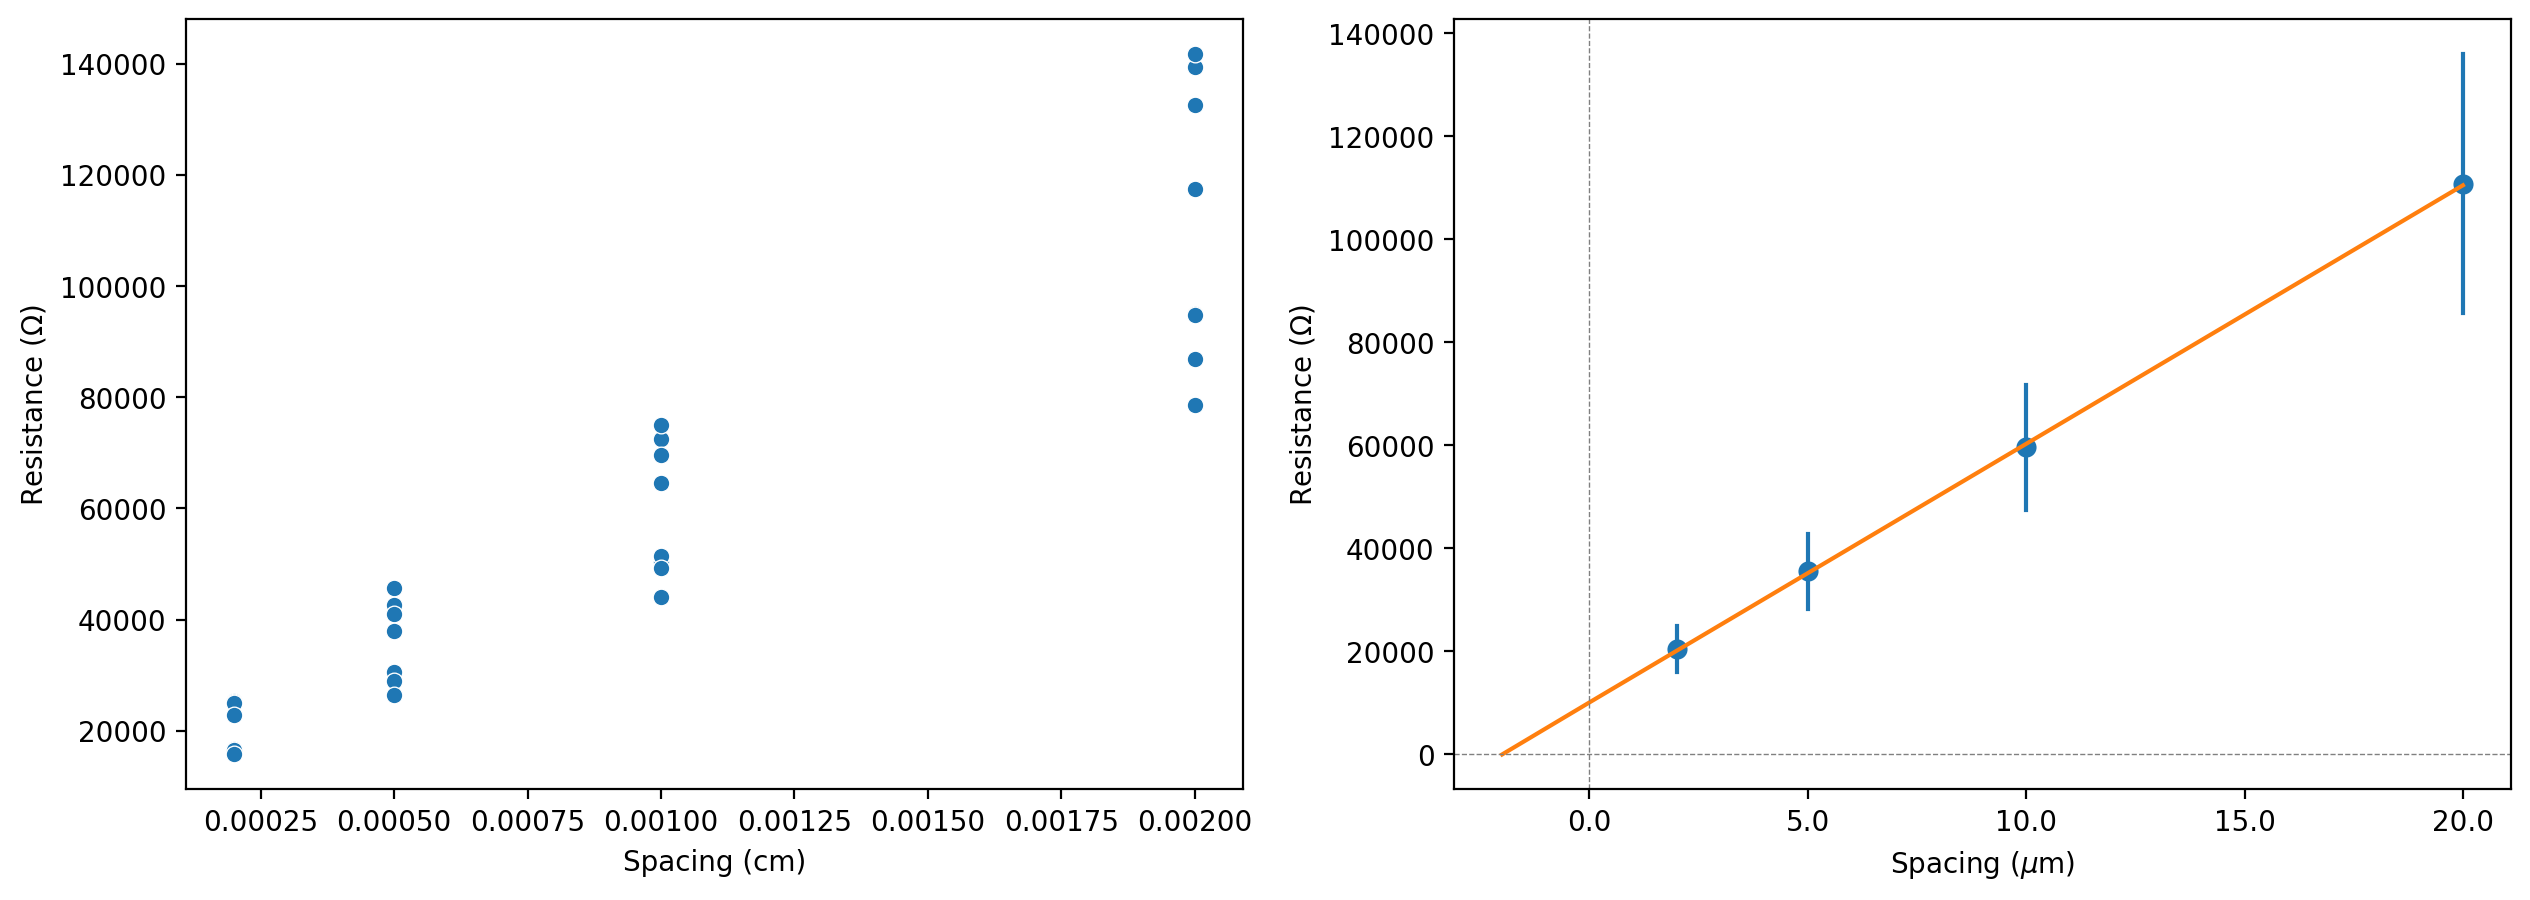

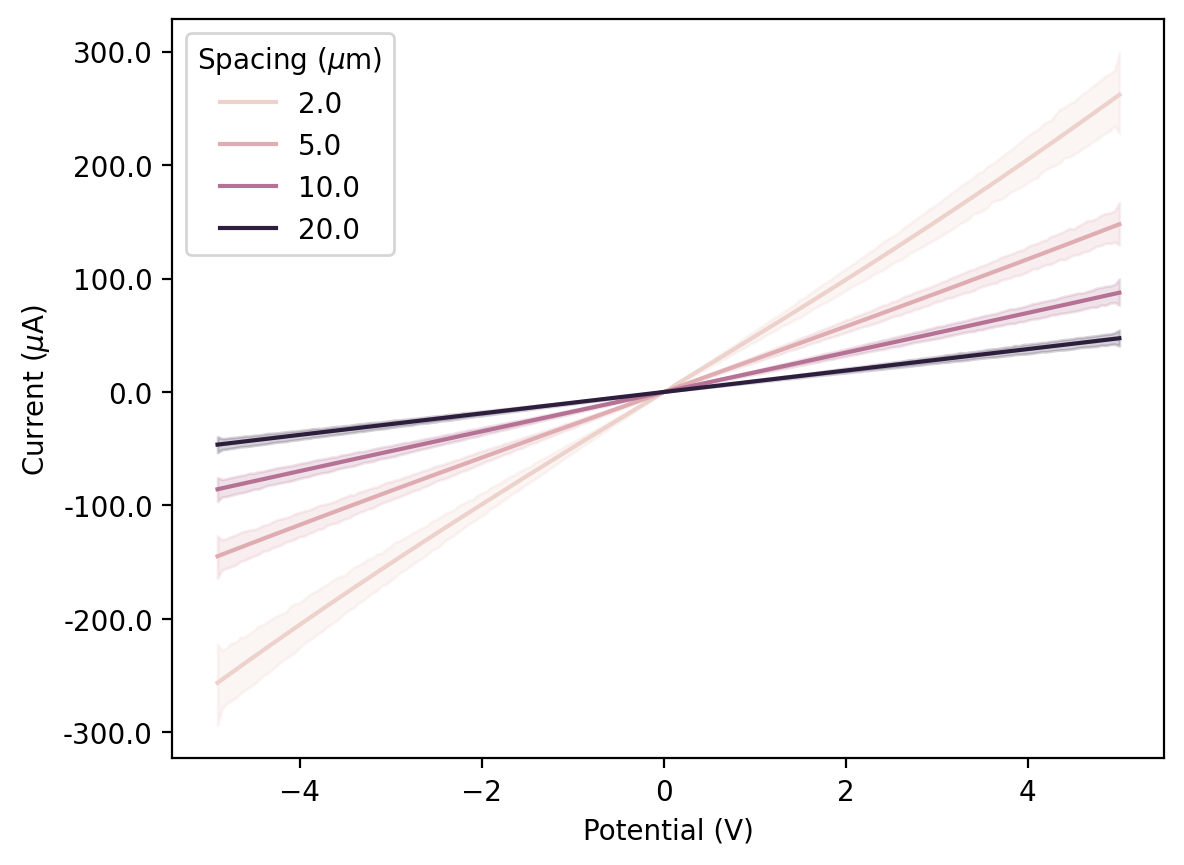

In [55]:
# LMO8h Au 1 2
path = r'C:\Users\lopezb41\OneDrive - imec\Documents\Experiments\Data\Contact Resistance\IDEA2_TLM\LMO8h_Au_20231106\both'
sample = 'LMO 350/Au'
lmo8h_au12 = C_R(path, 350, sample)
print(lmo8h_au12[1].fit_report())

Contact Resistivity = 4402800533.649483 Ohm cm2
LMO conductivity = 0.22062221100010992 S/cm


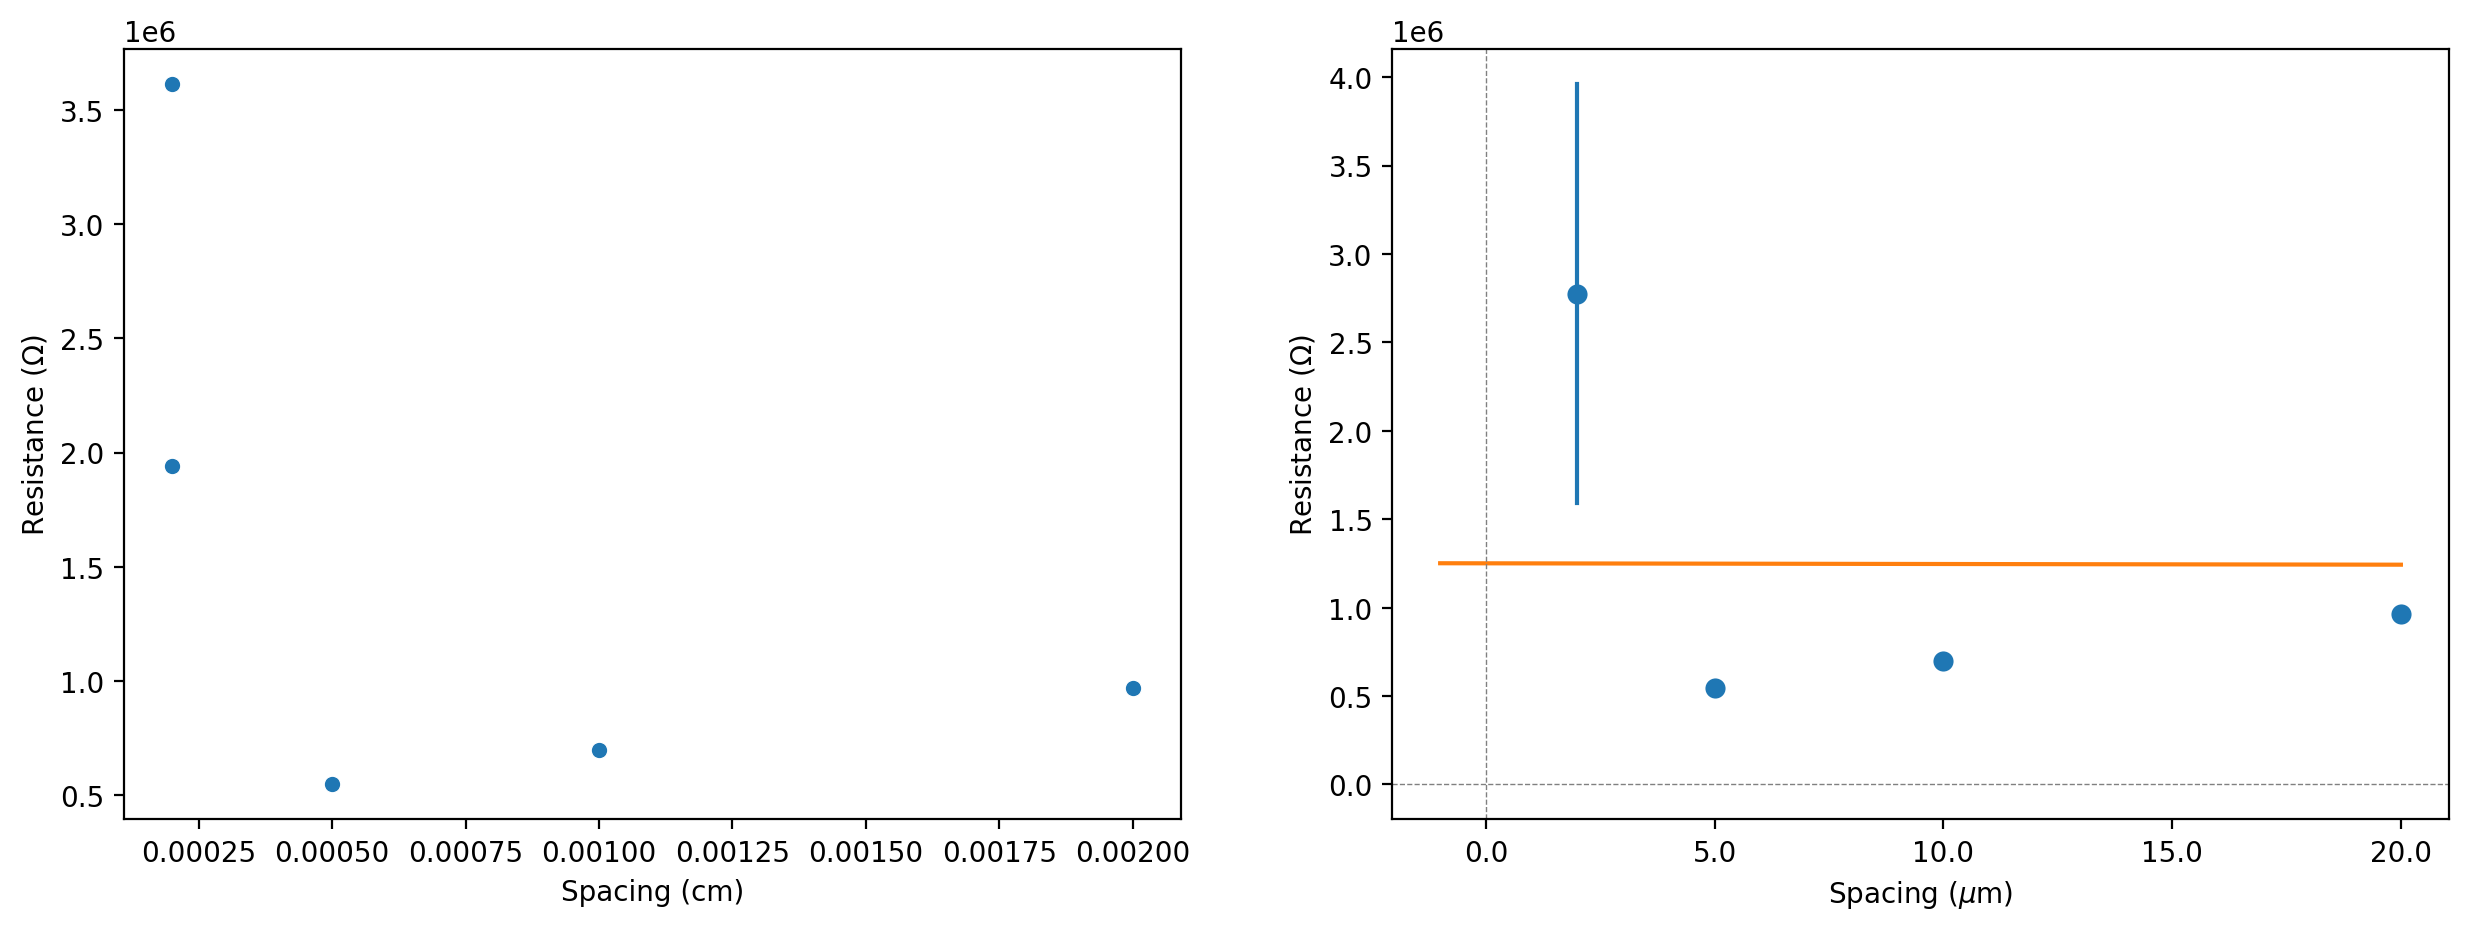

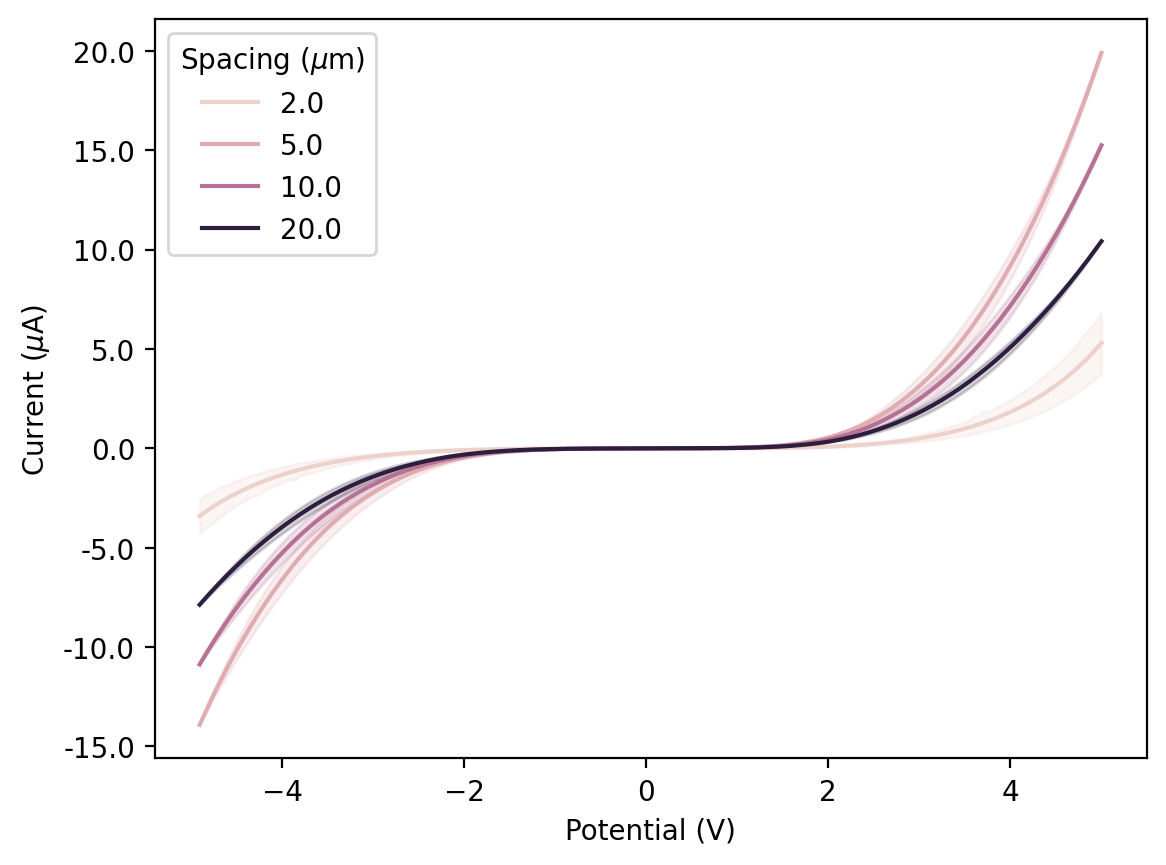

In [44]:
# LMO8h Al
path = r'C:\Users\lopezb41\OneDrive - imec\Documents\Experiments\Data\Contact Resistance\IDEA2_TLM\LMO8h_Al_220231106'
sample = 'LMO 350/Al'
lmo8h_al = C_R(path, 350, sample)


<AxesSubplot: >

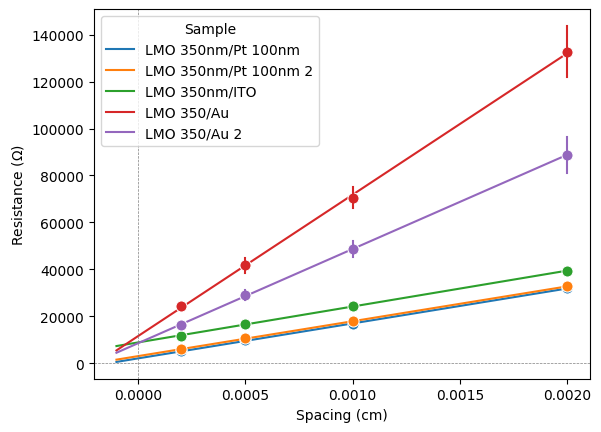

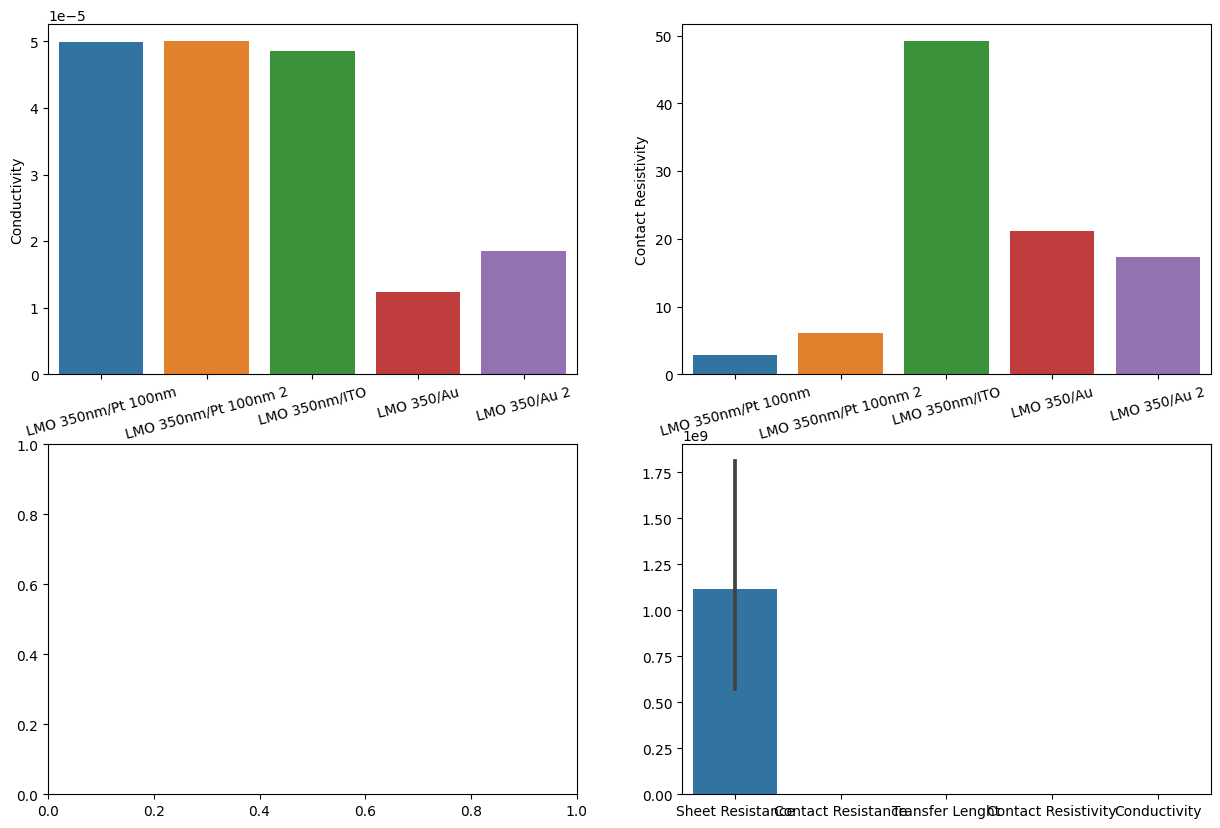

In [45]:
# Compare
fig, ax = plt.subplots(dpi = 100)
samples = [lmo8h_pt, lmo8h_pt2, lmo8h_ito, lmo8h_au, lmo8h_au2]
vals = pd.DataFrame()
fit_v = pd.DataFrame()
cross_zero = np.array([-1, 0, 20]) * 1e-4
for i in samples:
    vals = pd.concat([vals, i[0]], ignore_index = True)
    fit_v = pd.concat([fit_v, i[2]], ignore_index = True)
    y_zero = tlm_mod2.eval(i[1].params, s = cross_zero)
    sns.lineplot(x = cross_zero, y = y_zero)
sns.lineplot(data = vals, x = col2[1], y = col2[2], hue = 'Sample', marker='o', markersize = 8, errorbar='sd',err_style='bars', linestyle='')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)  # Horizontal zero line
plt.axvline(0, color='gray', linestyle='--', linewidth=0.5)  # Vertical zero 
fig, ax = plt.subplots(2, 2, figsize = (15,10), dpi = 100)
sns.barplot(data = fit_v, x = 'Sample', y = 'Conductivity', ax = ax[0,0])
sns.barplot(data = fit_v, x = 'Sample', y = 'Contact Resistivity', ax = ax[0,1])
ax[0,0].set_xticklabels(ax[0,0].get_xticklabels(), rotation=15)
ax[0,1].set_xticklabels(ax[0,0].get_xticklabels(), rotation=15)
sns.barplot(data = fit_v)
